## 1. Load Libraries

In [47]:
!pip install pywaffle
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pywaffle import Waffle
import matplotlib.pyplot as plt
from sklearn.metrics import *
from statsmodels.stats.weightstats import ztest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100

## 2. Load Data

In [49]:
df = pd.read_csv('https://raw.githubusercontent.com/saileshr9/Violent-crime-in-maryland/main/final.csv').iloc[:,1:]
print(f"shape : {df.shape}")
df.head(4)

shape : (14794, 21)


,season,round,circuit_id,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,nationality,constructor,grid,podium,driver_points,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,qualifying_time,driver_age
0,1983,1,jacarepagua,False,False,True,False,False,keke_rosberg,Finnish,williams,1,15,0,0,0,0,0,0,0.00,34
1,1983,1,jacarepagua,False,False,True,False,False,prost,French,renault,2,6,0,0,0,0,0,0,0.20,28
2,1983,1,jacarepagua,False,False,True,False,False,tambay,French,ferrari,3,4,0,0,0,0,0,0,0.30,33
3,1983,1,jacarepagua,False,False,True,False,False,piquet,Brazilian,brabham,4,1,0,0,0,0,0,0,0.60,30


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14794 entries, 0 to 14793
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   season                     14794 non-null  int64  
 1   round                      14794 non-null  int64  
 2   circuit_id                 14794 non-null  object 
 3   weather_warm               14794 non-null  bool   
 4   weather_cold               14794 non-null  bool   
 5   weather_dry                14794 non-null  bool   
 6   weather_wet                14794 non-null  bool   
 7   weather_cloudy             14794 non-null  bool   
 8   driver                     14794 non-null  object 
 9   nationality                14794 non-null  object 
 10  constructor                14794 non-null  object 
 11  grid                       14794 non-null  int64  
 12  podium                     14794 non-null  int64  
 13  driver_points              14794 non-null  int

## 3. Data Cleaning

In [51]:
df.isnull().sum() ## no null found

season                       0
round                        0
circuit_id                   0
weather_warm                 0
weather_cold                 0
weather_dry                  0
weather_wet                  0
weather_cloudy               0
driver                       0
nationality                  0
constructor                  0
grid                         0
podium                       0
driver_points                0
driver_wins                  0
driver_standings_pos         0
constructor_points           0
constructor_wins             0
constructor_standings_pos    0
qualifying_time              0
driver_age                   0
dtype: int64

In [52]:
df[df.duplicated()].shape[0] ## no duplicate found

0

In [53]:
df['weather_warm'] = df['weather_warm'].map({True : 'warm', False : np.nan})
df['weather_cold'] = df['weather_cold'].map({True : 'cold', False : np.nan})
df['weather_dry'] = df['weather_dry'].map({True : 'dry', False : np.nan})
df['weather_wet'] = df['weather_wet'].map({True : 'wet', False : np.nan})
df['weather_cloudy'] = df['weather_cloudy'].map({True : 'cloudy', False : np.nan})

In [54]:
## getting each seasons total rounds and max round present in the dataset
dftemp = df.groupby('season')['round'].unique().reset_index()
dftemp['total_round'] = dftemp['round'].apply(lambda x : len(x))
dftemp['max_round'] = dftemp['round'].apply(lambda x : max(x))
dftemp.drop(columns = 'round', inplace=True)

## merge calcuated fields with the main dataset
df1 = df.merge(dftemp, on = ['season'])

## creating feature to keep the last seasons
df1['last_round_flag'] = df1['max_round'] - df1['round']
df1['last_round_flag'] = df1['last_round_flag'].apply(lambda x : 1 if x == 0 else 0)

## first round flag
df1['first_round_flag'] = df1['round'].apply(lambda x : x if x == 1 else 0)

## 4. Basic Functions

In [55]:
def labelPlotting(xClass,
                  yClass,
                  rotation=0,
                  color='seashell',
                  va = 'top'):
    for idx, (value, height) in enumerate(zip(xClass, yClass)):
        plt.text(idx, height, ' '+ str(value), color = color,
                 ha = 'center', va = va, rotation = rotation)
        

def cricularPlot(dFrame, data, text, title,
                 figsize=(10,10), color = 'indigo',
                 padding = 4):
    """
    This function plots a circular plot.
    """
    plt.figure(figsize=figsize)
    ax = plt.subplot(111, polar=True)
    plt.axis('off')
    
    ## setting up limits
    lowerLimit = 5
    upperLimit = 100
    
    ## creating slope and height for the bars for circular plot
    ## it will be converted into values between 5 and 100
    slope = (dFrame[data].max() - lowerLimit)/dFrame[data].max()
    heights = slope * dFrame[data] + lowerLimit
    
    ## width of each bar
    width = 2*np.pi / len(dFrame.index)
    
    ## computing angle and indexes
    indexes = list(range(1,len(dFrame.index)+1))
    angles = [element * width for element in indexes]
    angles
    
    ## creating bars
    bars = ax.bar(x=angles, height=heights, width=width, 
                  bottom=lowerLimit, linewidth=2, color =color,
                  edgecolor="white")

    labelPadding = padding ## space between bar and labels

    # adding labels to the dataset
    for bar, angle, height, label in zip(bars,angles, 
                                         heights, 
                                         dFrame[text]):

        rotation = np.rad2deg(angle) ## rotation for each plot
        
        alignment = "" ## flipping some labels upside down
        if angle >= np.pi/2 and angle < 3*np.pi/2:
            alignment = "right"
            rotation = rotation + 180
        else: 
            alignment = "left"

        # Finally add the labels
        ax.text(x=angle,  y=lowerLimit + bar.get_height() + labelPadding, 
            s=label, ha=alignment, va='center', 
            rotation=rotation, rotation_mode="anchor") 
    ax.set_title(title)
    
    
def donoughtPlot(values, label, size, title):
    """
    This function plots a donought plot.
    """
    plt.figure(figsize=size)
    plt.pie(values, labels=label, 
            autopct = lambda x: '{:.0f}'.format(x*values.sum()/100),
            pctdistance=0.85)
    plt.title(title)
    centreCircle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centreCircle) ## add to the pie graph

## 5. Basic EDA

In [56]:
print("Data consists of how many seasons?")
print(f"ans : {len(df['season'].unique())}")
print(f"Start Season : {df['season'].unique()[0]}, Last Season : {df['season'].unique()[-1]}")

Data consists of how many seasons?
ans : 39
Start Season : 1983, Last Season : 2021


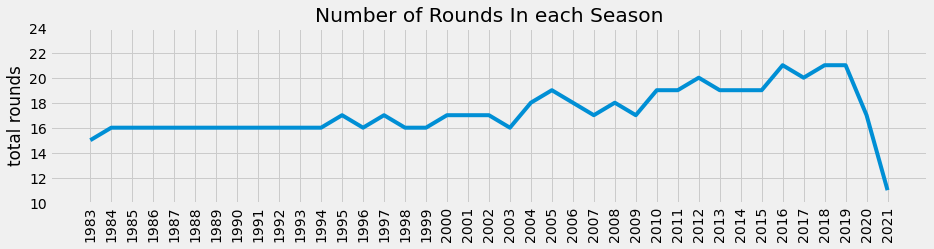

In [57]:
## how many rounds of races happended in each season?

## getting seasons and max rounds for each season
P1 = df1.drop_duplicates(['season', 'max_round'])
plt.figure(figsize=(14,3))
plt.plot(P1['season'].astype(str), P1['max_round'])
plt.xticks(rotation = 90)
plt.yticks(range(10, 26, 2))
plt.ylabel('total rounds')
plt.title('Number of Rounds In each Season')
plt.show()

**With chronological change of seasons the number of more races being introduced. Though due to covid in season 2020, and 2021 the number of races are less(17,10) as compared to nearest seasons.**

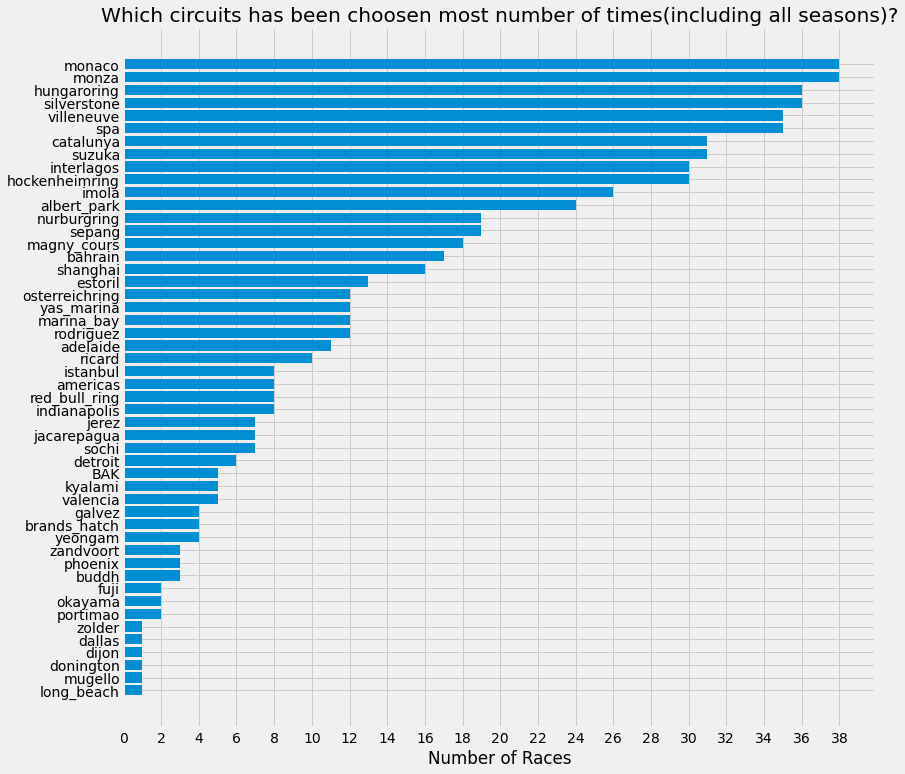

In [58]:
## On which circuit most number of races has been happened?

P2 = df1.drop_duplicates(['season', 'circuit_id'])\
    .groupby('circuit_id')['circuit_id'].count()\
    .reset_index(name = 'total_race')\
    .sort_values(by = 'total_race')

plt.figure(figsize=(12,12))
plt.barh(P2.circuit_id, P2.total_race)
plt.xticks(range(0, 40, 2))
plt.xlabel('Number of Races')
plt.title('Which circuits has been choosen most number of times(including all seasons)?')
plt.show()

**Out of 39 seasons, for 38 seasons monaco and monza has hosted a race, which is the highest number of races happended present in the dataset.**

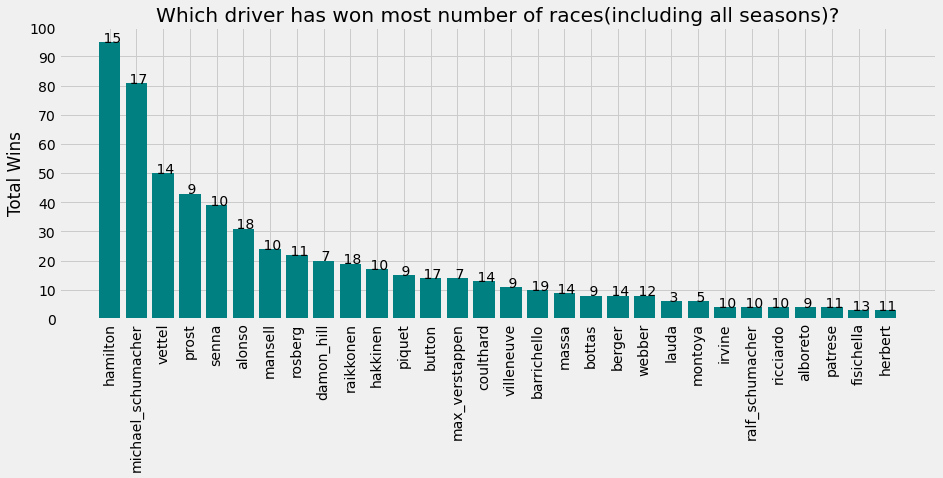

In [59]:
## which driver has most number of wins?(top 30)

P3 = df1[df1['last_round_flag'] == 1].groupby('driver').agg({'driver_wins' : ['sum', 'count']}).reset_index()
P3.columns = ['driver', 'driver_wins', 'driver_total_season']
P3.sort_values(by = 'driver_wins', ascending=False, inplace=True)

P3Ext = P3.iloc[0:30]
plt.figure(figsize=(14,5))
plt.bar(P3Ext['driver'], P3Ext['driver_wins'], color='teal')
plt.xticks(rotation = 90)
plt.yticks(range(0,101,10))
plt.ylabel('Total Wins')
plt.title('Which driver has won most number of races(including all seasons)?')

for idx, (value, height) in enumerate(zip(P3Ext['driver_total_season'], P3Ext['driver_wins'])):
    plt.text(idx, height, ' '+ str(value), color = 'black',
             ha = 'center', va = 'baseline',rotation = 0)

plt.show()

**Lewis Hamilton and Micheal Sachumacher are two prominant F1 drivers who have won 95, and 80 races in throughout the years. The 3rd person on the list is Sebastian Vettel who has 50 races win in total.**


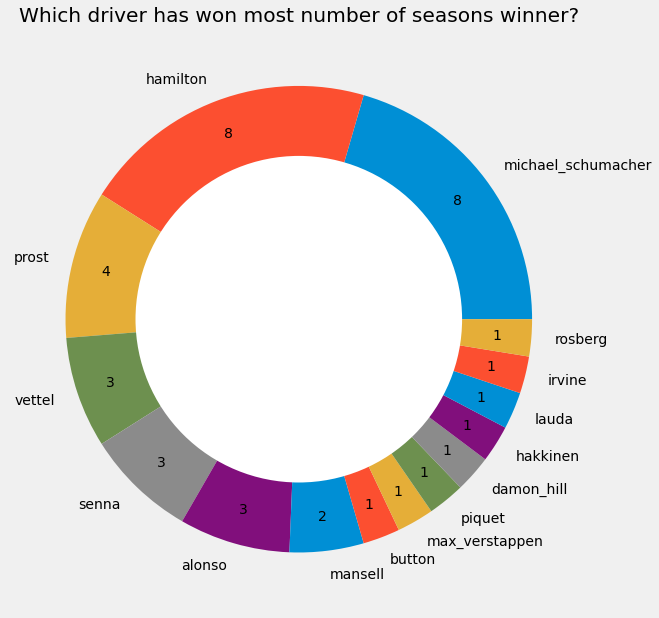

In [60]:
P4 = df1[(df1['last_round_flag'] == 1) &
         (df1['driver_standings_pos'] == 1)]['driver'].value_counts().reset_index()

donoughtPlot(P4['driver'], 
             P4['index'],
             (10,10), 
             'Which driver has won most number of seasons winner?',)

**Most number of seasons won by Lewis Hamilton and Micheal Schumacher which is 8.**

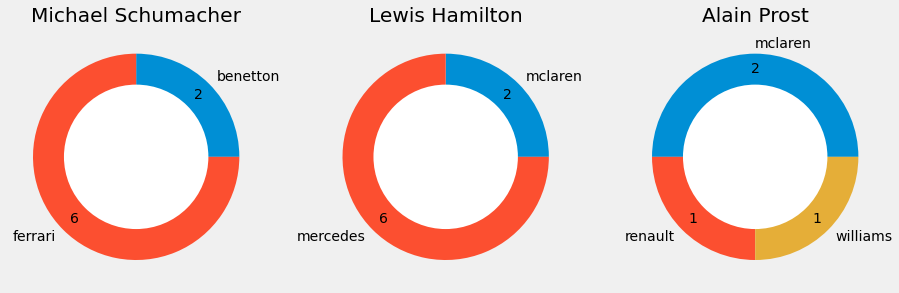

In [61]:
## Michael_Schumacher, Alain Prost and Lewis Hamilton wins with different constructor

P4_1 = df1[(df1['last_round_flag'] == 1) &
           (df1['driver_standings_pos'] == 1)]\
           [['driver', 'constructor']]\
           .groupby(['driver', 'constructor'])\
           ['constructor'].count().reset_index(name = 'wins')

MS = P4_1[P4_1['driver'] == 'michael_schumacher']
LH = P4_1[P4_1['driver'] == 'hamilton']
AP = P4_1[P4_1['driver'] == 'prost']

plt.figure(figsize=(14,5))
plt.subplot(131)
plt.pie(MS['wins'], labels=MS['constructor'], 
            autopct = lambda x: '{:.0f}'.format(x*MS['wins'].sum()/100),
            pctdistance=0.85)
plt.title('Michael Schumacher')
centreCircle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centreCircle)


plt.subplot(132)
plt.pie(LH['wins'], labels=LH['constructor'], 
            autopct = lambda x: '{:.0f}'.format(x*LH['wins'].sum()/100),
            pctdistance=0.85)
plt.title('Lewis Hamilton')
centreCircle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centreCircle)


plt.subplot(133)
plt.pie(AP['wins'], labels=AP['constructor'], 
            autopct = lambda x: '{:.0f}'.format(x*AP['wins'].sum()/100),
            pctdistance=0.85)
plt.title('Alain Prost')
centreCircle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centreCircle)

plt.show()

In [62]:
## driver performance with different condition

## warm
P5 = (df1[(df1['podium'] == 1) & (df1['weather_warm'] == 'warm')]\
     .groupby('driver')['driver'].count()\
     .reset_index(name = 'total_wins')).sort_values(by = 'total_wins', 
                                                    ascending=False,)

## cold
P6 = (df1[(df1['podium'] == 1) & (df1['weather_cold'] == 'cold')]\
     .groupby('driver')['driver'].count()\
     .reset_index(name = 'total_wins')).sort_values(by = 'total_wins',
                                                    ascending=False,)

## dry
P7 = (df1[(df1['podium'] == 1) & (df1['weather_dry'] == 'dry')]\
     .groupby('driver')['driver'].count()\
     .reset_index(name = 'total_wins')).sort_values(by = 'total_wins',
                                                    ascending=False,)

## wet
P8 = (df1[(df1['podium'] == 1) & (df1['weather_wet'] == 'wet')]\
     .groupby('driver')['driver'].count()\
     .reset_index(name = 'total_wins')).sort_values(by = 'total_wins',
                                                    ascending=False,)

## cloudy
P9 = df1[(df1['podium'] == 1) & (df1['weather_cloudy'] == 'cloudy')]\
     .groupby('driver')['driver'].count()\
     .reset_index(name = 'total_wins').sort_values(by = 'total_wins',
                                                   ascending=False,)

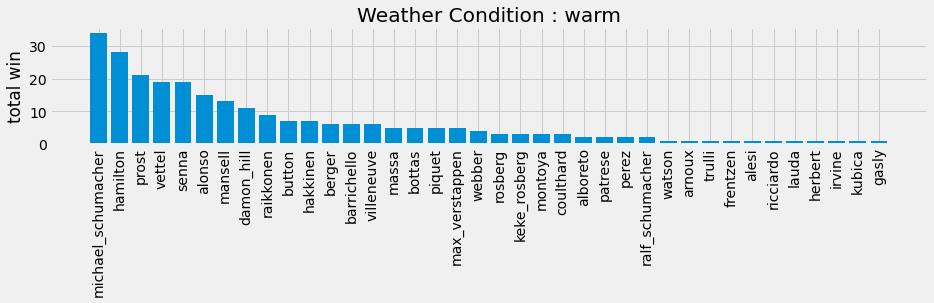

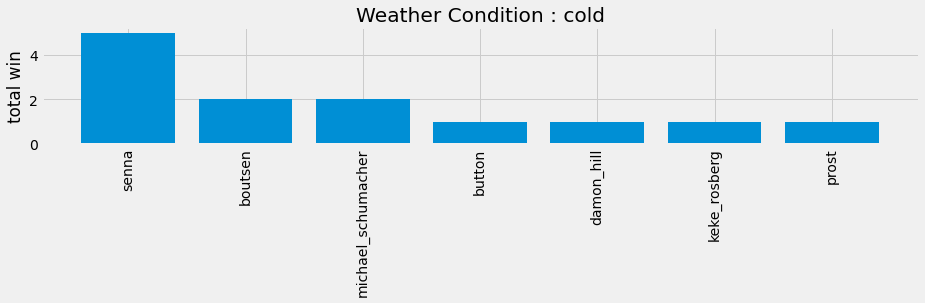

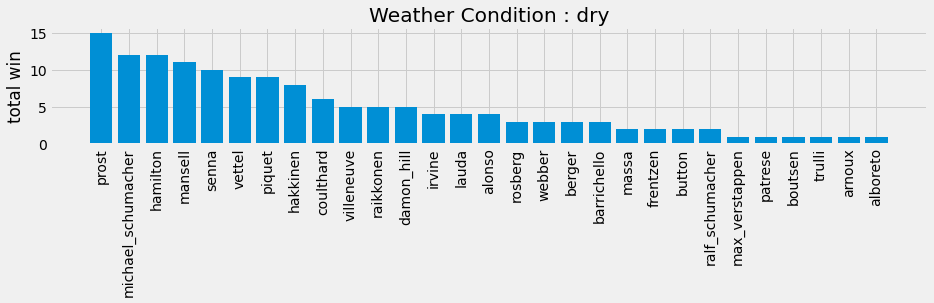

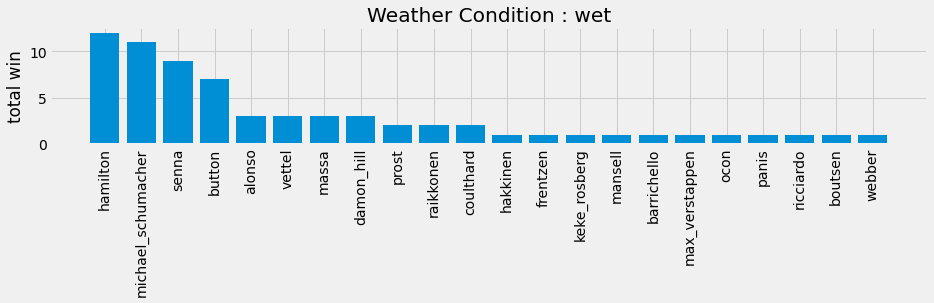

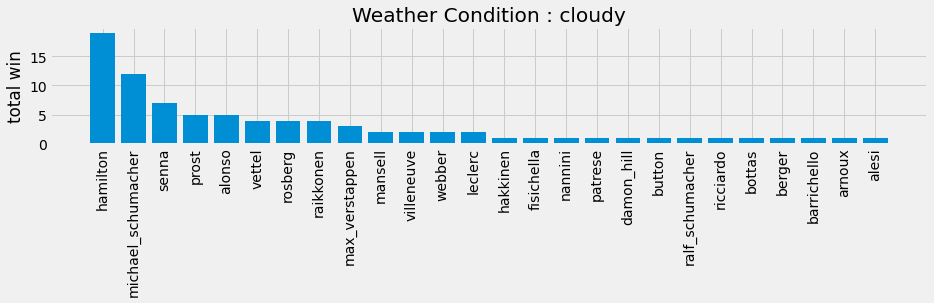

In [63]:
for dFrame, weatherCondition in zip([P5, P6, P7, P8, P9],
                                    ['warm', 'cold', 'dry', 'wet', 'cloudy']):
    plt.figure(figsize=(14,2))
    plt.bar(dFrame.driver, dFrame.total_wins)
    plt.xticks(rotation=90)
    plt.ylabel('total win')
    plt.title(f'Weather Condition : {weatherCondition}')
plt.show()

**Lewis Hamilton performs better on cloudy, wet, and warm condition. Michael Schumacher more wins in warm weather as compared to Hamilton. Suprisingly in dry weather condition Prost is the best driver, and in cold condition Seena.**

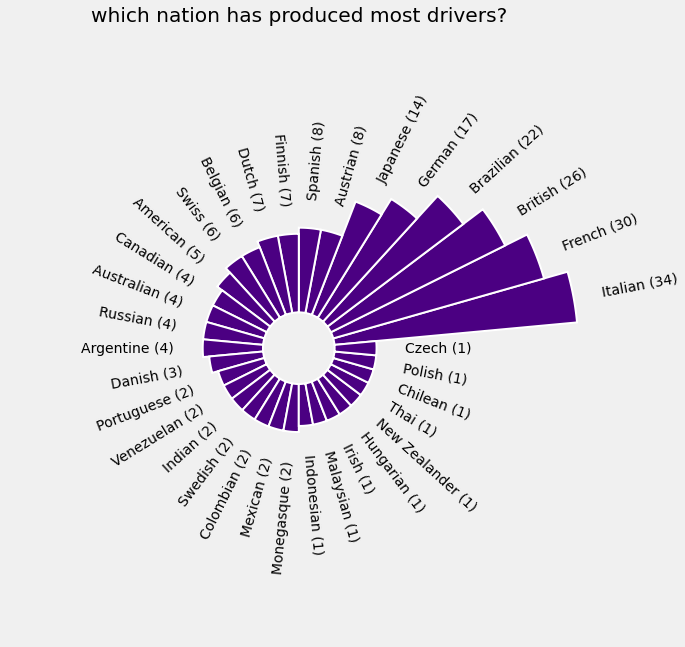

In [64]:
## which nation has produced more drivers ?

P10 = df1.drop_duplicates(['driver', 'nationality'])['nationality'].value_counts().reset_index()
P10.columns = ['nationality', 'driver_count']
P10['text'] = P10['nationality'] + " (" + P10['driver_count'].astype(str) + ")"

cricularPlot(P10, 'driver_count', 'text', 'which nation has produced most drivers?',
             figsize=(10,10), color = 'indigo')

**Italy, France, British, Brazil, and Germany are some of the countries which has more drivers competiting every season.**

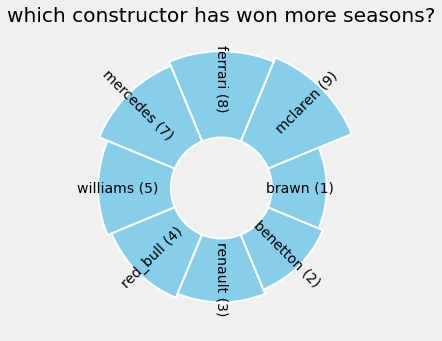

In [65]:
## which constructor has won more seasons?

P11 = df1[(df1['last_round_flag'] == 1) & (df1['driver_standings_pos'] == 1)]['constructor']\
        .value_counts().reset_index()
P11.columns = ['constructor', 'season_wins']
P11['text'] = P11['constructor'] + " (" + P11['season_wins'].astype(str) + ")"


cricularPlot(P11, 'season_wins', 'text', 'which constructor has won more seasons?',
             figsize=(5,5), color = 'skyblue',
            padding=-6)

**Maclearn has the highest season wins.**

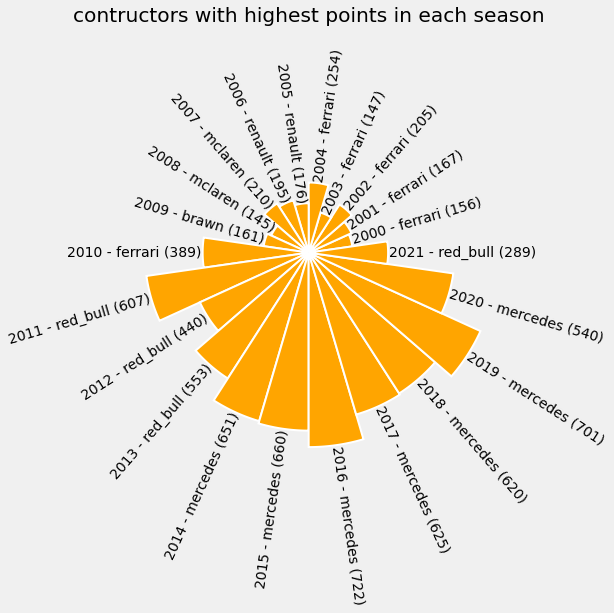

In [66]:
## contructors with highest points in 21st century
P12 = df1[(df1['last_round_flag'] == 1)
          & (df1['driver_standings_pos'] == 1)]\
          [['season','constructor','constructor_points']]
P12['text'] = P12['season'].astype(str) + ' - ' + P12['constructor'] + \
            ' (' + P12['constructor_points'].astype(str) + ')'
P12 = P12[P12['season'] >= 2000]

cricularPlot(P12, 'constructor_points', 'text', 'contructors with highest points in each season',
             figsize=(7,7), color = 'orange',
            padding=4)

**With every season the points are inceasing for each winning contructor. It many happen due to the number of races being introduced more with each season.**

**Also we can see mercedes has dominated the circuits since 2014 onwards.**

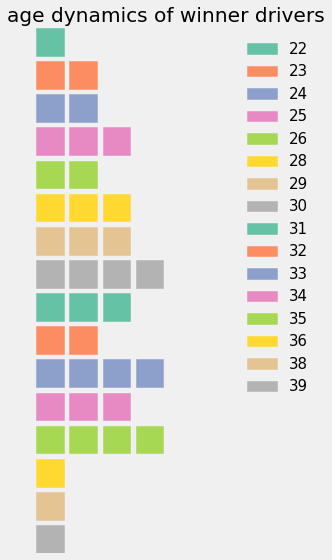

In [67]:
## What age winners when they won the seasons?
P16 = df1[(df1['last_round_flag'] == 1) &
          (df1['driver_standings_pos'] == 1)]['driver_age'].value_counts().reset_index()
P16.columns = ['driver_age', 'wins']
P16['driver_age'] = P16['driver_age'].astype(str)

P17 = {val[0] : val[1] for val in P16.sort_values('driver_age').values}

fig = plt.figure(FigureClass=Waffle,
                 figsize=(13,8),
                 values=P17,
                 columns=8,
                 vertical=True,
                 starting_location='NW',
                 block_arranging_style='new-line',
                 icon_legend=True,
                 legend={'bbox_to_anchor': (1.1,1), 
                         'fontsize': 15, 
                         'frameon': False})
plt.title('age dynamics of winner drivers')
plt.show()

**The above dynamics shows how many times a driver has won a season at the certain age. It shows the oldest to win a season is at 39 years, where as the yongest is at 22 years. Winners having the age 35, 33, and 30 has the highest wins which is 4.**

## 6. Hypothesis Formulation

### Problem 1

We saw Michael Schumacher and Lewis Hamilton both have won 8 seasons and almost closer individual wins. They have also won the same number of seasons with different contructors(2 and 6). So are they performing similar way through out the seasons, or they are significantly different from each other(only stats are similar)?

#### H0 : The podium position acheived by Michael Schumacher and Lewis Hamilton  throught their driving seasons are same.

#### H1 : The podium position acheived by Michael Schumacher and Lewis Hamilton  throught their driving seasons are different.

In [68]:
## dropping the season 2021 as there are less races happened
htDf = df1[(df1['season'] != 2021)]

## creating data for michael_schumacher and hamilton
mc_podium = htDf[htDf['driver'] == 'michael_schumacher']['podium'].values
lh_podium = htDf[htDf['driver'] == 'hamilton']['podium'].values

alpha = 0.05
stat ,p_value  = ztest(mc_podium, x2=lh_podium, value=0)

if p_value <= alpha:
    print(f'Since the p-value, {round(p_value, 5)} < {alpha} (alpha) the difference is significant and we reject the Null hypothesis')
else:
    print(f'''\t Since the p-value, {round(p_value,5)} > {alpha} (alpha) the difference is not significant and,
    \t we fail to reject the Null hypothesis''')

Since the p-value, 0.00047 < 0.05 (alpha) the difference is significant and we reject the Null hypothesis


**The above hypothesis formulated by us says there is significant difference between the podium finish done by  Schumacher and Hamilton is different. This may be due to in recent seasons the number of races being added more as compared to Schumacher's era.**

### Problem 2

#### H0 : The standing position each season end acheived by Michael Schumacher and Lewis Hamilton  throught their driving seasons are same.

#### H1 : The standing position each season end acheived  Michael Schumacher and Lewis Hamilton  throught their driving seasons are different.

In [69]:
## selecting only last position
htDf1 = htDf[htDf['last_round_flag'] == 1]

## creating data for michael_schumacher and hamilton
mc_podium = htDf1[htDf1['driver'] == 'michael_schumacher']['constructor_standings_pos'].values
lh_podium = htDf1[htDf1['driver'] == 'hamilton']['constructor_standings_pos'].values

alpha = 0.05
stat ,p_value  = ztest(mc_podium, x2=lh_podium, value=0)

if p_value <= alpha:
    print(f'Since the p-value, {round(p_value, 5)} < {alpha} (alpha) the difference is significant and we reject the Null hypothesis')
else:
    print(f'''\t Since the p-value, {round(p_value,5)} > {alpha} (alpha) the difference is not significant and,
    \t we fail to reject the Null hypothesis''')

	 Since the p-value, 0.94429 > 0.05 (alpha) the difference is not significant and,
    	 we fail to reject the Null hypothesis


**As we know both the driver has won same number of seasons and races, so there is no difference in between their final podium position. And the output p value is very high which says their winning behaviour is almost same.**

## 7. Distribution Analysis

In [70]:
def distributionPlot(dframe, columns, size, rows, cols):
    """
    This function is to plot distribution and kernel
    density estimation for numerical features.
    """
    plt.figure(figsize=size)
    for idx, col in enumerate(columns):
        plt.subplot(rows, cols, idx+1)
        sns.distplot(dframe[col])
        plt.title(col)
        plt.xlabel('')
    plt.show()

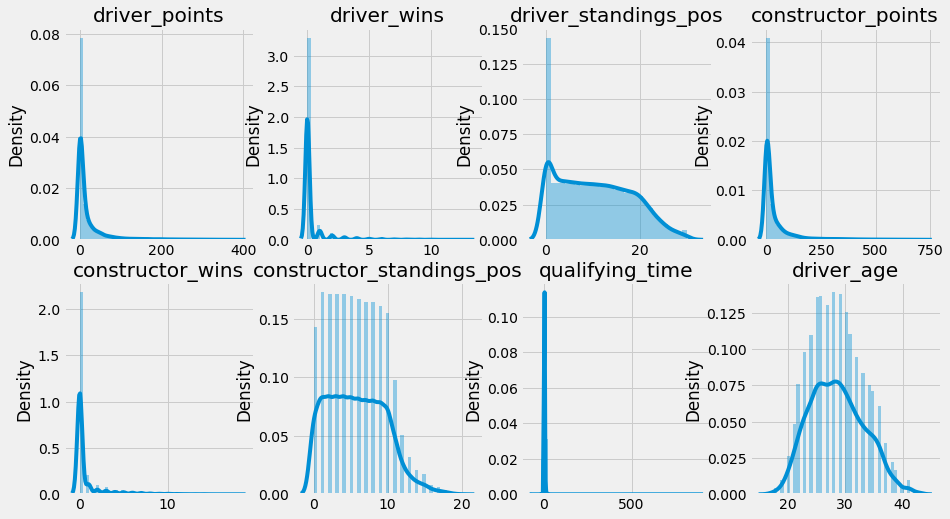

In [71]:
## distribution plot columns list
distColList = ['driver_points', 'driver_wins','driver_standings_pos', 
               'constructor_points', 'constructor_wins', 
               'constructor_standings_pos', 'qualifying_time', 
               'driver_age',]

distributionPlot(df1, distColList, (14,8), 2, 4)

**Other than age none of the features look like normally distributed.**

## 8. Correlation Analysis

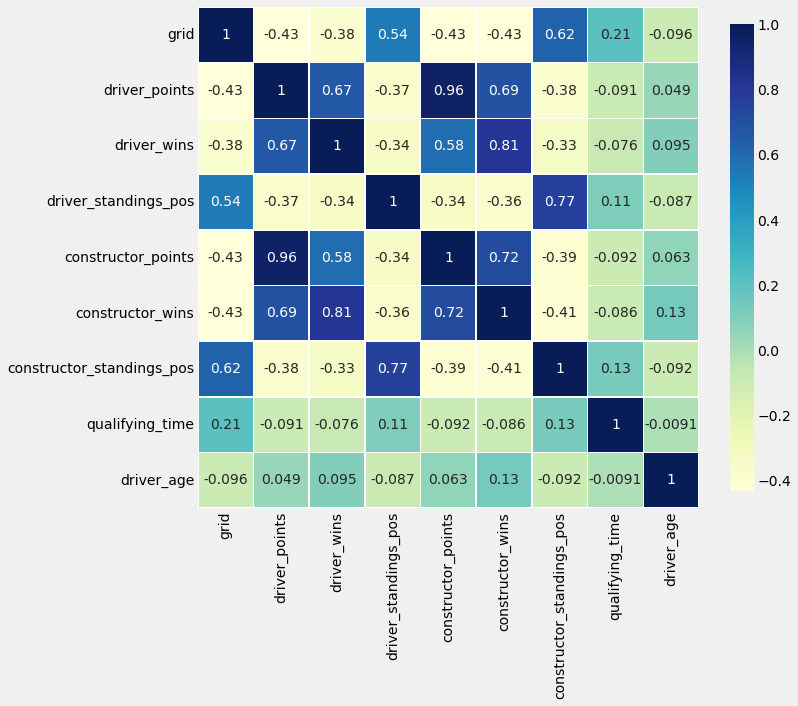

In [72]:
## selecting important input columns for corr analysis
corrColList = ['grid','driver_points', 'driver_wins','driver_standings_pos', 
               'constructor_points', 'constructor_wins', 
               'constructor_standings_pos', 'qualifying_time', 
               'driver_age',]

fig = plt.figure(figsize=(10,10))
plot = sns.heatmap(df1[corrColList].corr(), square = True, 
                   linewidths = .5, cbar_kws = {"shrink":0.8}, 
                   annot = True, cmap = 'YlGnBu') 

1. There is a high positive correlation between driver_points and constructor_points which is 0.96.
2. 0.81 correlation is shown between driver_wins and constructor_wins.

It means if a driver is winning the number of races it will impact the constructors position and points as well. So for one case there is a multicollinearity present in the dataset.

## 9. Correlation Analysis with Output

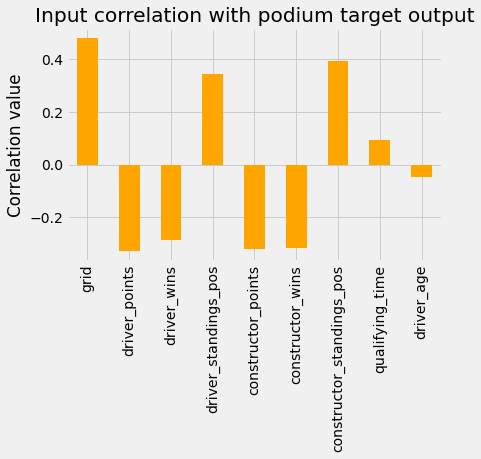

In [73]:
plot = df1[corrColList].corrwith(df1['podium']).plot(kind = 'bar', color = 'orange')
plt.title('Input correlation with podium target output')
plt.ylabel('Correlation value')
plt.show()

**There is no higher correlationship between input and ouput feature.**

## 10. Feature Selection and Data Splitting

In [74]:
## selecting only important feature which has an impact on the output data
## driver, nationality will make the model bias as some driver has only highest podium positions
## season has no impact over podium
## removing created features such as total_round, max_round, last_round_flag, first_round_flag
df2 = df1.drop(columns = ['season', 'driver', 'nationality',
                          'total_round', 'max_round', 
                          'last_round_flag', 'first_round_flag'])
print(f'final shape : {df2.shape}')


## filling all na present in weather data into '0'
df2 = df2.fillna('0')

final shape : (14794, 18)


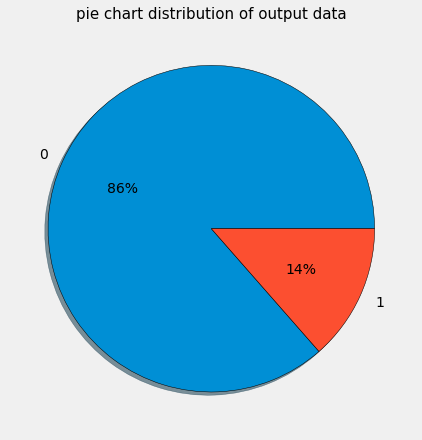

In [75]:
## as we have a high number of output label which starts from 1 to 30
## i am converting the column into binrary where i'll
## make podium 1,2,3 as podium finisher(1) whereas rest not podium finisher(0)
df2['target'] = df2['podium'].apply(lambda x : 0 if x > 3 else 1)

data = df2['target'].value_counts().to_dict()
plt.figure(figsize=(7,7))
plt.pie(data.values(), labels = data.keys(), 
        wedgeprops={'edgecolor': 'black'}, colors = ['#008fd5', '#fc4f30'], autopct='%.0f%%', shadow=True)
plt.title("pie chart distribution of output data", fontsize=15)
plt.show()

**As we can see here the target class is imbalance and highly likely chance model may bias towards the output class.**

In [76]:
y = df2['target']
X = df2.drop(columns = ['podium', 'target'])

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, 
                                                stratify=y, random_state=2)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((11835, 17), (2959, 17), (11835,), (2959,))

## 11. Data Encoding

In [77]:
## there are 7 categorical columns which needs to be encoded into labels
## categorical column list
catColList = ['circuit_id', 'weather_warm', 'weather_cold',
              'weather_dry', 'weather_wet', 'weather_cloudy',
              'constructor']

## label encoding
for col in catColList:
    encoder = LabelEncoder()
    encoder.fit(df2[col])
    xtrain[col] = encoder.transform(xtrain[col])
    xtest[col] = encoder.transform(xtest[col])

In [78]:
## standard scaling
for col in xtrain.columns:
    encoder = StandardScaler()
    encoder.fit(xtrain[[col]])
    xtrain[col] = encoder.transform(xtrain[[col]])
    xtest[col] = encoder.transform(xtest[[col]])

## 12. Model Building using LazyPredict 

In [79]:
from lazypredict.Supervised import LazyClassifier

## set up the model object
model = LazyClassifier(verbose=0, ignore_warnings=True)

## train model
models, prediction = model.fit(xtrain, xtest, ytrain, ytest)
models = models.reset_index()

100%|██████████| 29/29 [00:57<00:00,  2.00s/it]


In [80]:
## printing the top 5 models from the output result
models.iloc[0:5]

,Model,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
0,QuadraticDiscriminantAnalysis,0.86,0.82,0.82,0.88,0.17
1,GaussianNB,0.88,0.82,0.82,0.89,0.14
2,NearestCentroid,0.87,0.81,0.81,0.88,0.12
3,BernoulliNB,0.84,0.80,0.80,0.85,0.06
4,AdaBoostClassifier,0.90,0.75,0.75,0.89,1.43


**The 3 best model generated by lazy predict is QuadraticDiscriminantAnalysis, GaussianNB, and NearestCentroid. I am going to apply hyperparameter tuning(if enough parameters present) to tune the models and make it more efficient.**

**Note as the target class is imbalance we must optimize recall score to check the model performance on minority class.**

## 13. NearestCentroid

In [81]:
def validationOutput(name, ytrain, ytrainPred, ytest, yTestPred):
    """
    This function adds all validation output values to a dataframe.
    """
    df_ = pd.DataFrame()
    df_['ModelName'] = [name]
    df_['trainAcc'] = [accuracy_score(ytrain, ytrainPred)]
    df_['testAcc'] = [accuracy_score(ytest, yTestPred)]
    df_['testF1'] = [f1_score(ytest, yTestPred)]
    df_['testPrecision'] = [precision_score(ytest, yTestPred)]
    df_['testRecall'] = [recall_score(ytest, yTestPred)]
    return df_

In [82]:
from sklearn.neighbors import NearestCentroid

param_grid = {"metric" : ['euclidean', 'manhattan', 'cityblock'],
              'shrink_threshold' : [i*0.1 for i in range(0,11)]}

hpTuning = GridSearchCV(NearestCentroid(), param_grid, scoring='recall')
hpTuning.fit(xtrain, ytrain)

print("Best cross-validation score: {:.2f}".format(hpTuning.best_score_))
print("Best parameters: ", hpTuning.best_params_)
print("Best Estimator : ", hpTuning.best_estimator_)

Best cross-validation score: 0.79
Best parameters:  {'metric': 'manhattan', 'shrink_threshold': 1.0}
Best Estimator :  NearestCentroid(metric='manhattan', shrink_threshold=1.0)


In [83]:
model = hpTuning.best_estimator_
model.fit(xtrain, ytrain)

ytrainPred = model.predict(xtrain)
yTestPred = model.predict(xtest)

dfNC = validationOutput('Nearest Centroid', ytrain, ytrainPred, ytest, yTestPred)

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2558
           1       0.48      0.82      0.61       401

    accuracy                           0.86      2959
   macro avg       0.72      0.84      0.76      2959
weighted avg       0.90      0.86      0.87      2959



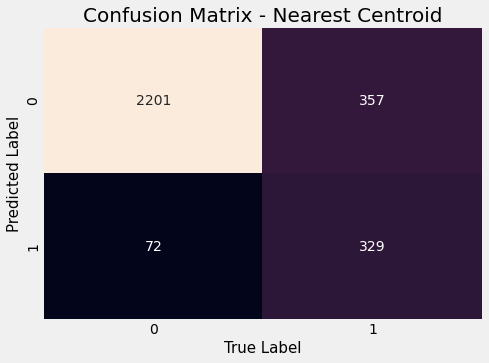

In [84]:
print(classification_report(ytest, yTestPred))

plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(ytest, yTestPred), annot=True, fmt="d", cbar=False)
plt.ylabel('Predicted Label', fontsize=15)
plt.xlabel('True Label', fontsize=15)
plt.title('Confusion Matrix - Nearest Centroid', fontsize=20)
plt.show()

### Observations:

1. Model is not overfitting as train and test roc curve as well as auc scores are very close.
2. The minority class F1 Score is 61% where as the recall is high and the missclassification is also very low.  

## 14. GaussianNB

In [85]:
from sklearn.naive_bayes import GaussianNB

param_grid = {"var_smoothing" : np.logspace(0,-9, num=200)}

hpTuning = GridSearchCV(GaussianNB(), param_grid, scoring='recall')
hpTuning.fit(xtrain, ytrain)

print("Best cross-validation score: {:.2f}".format(hpTuning.best_score_))
print("Best parameters: ", hpTuning.best_params_)
print("Best Estimator : ", hpTuning.best_estimator_)

Best cross-validation score: 0.66
Best parameters:  {'var_smoothing': 0.00036543830709572547}
Best Estimator :  GaussianNB(var_smoothing=0.00036543830709572547)


In [86]:
model = hpTuning.best_estimator_
model.fit(xtrain, ytrain)

ytrainPred = model.predict(xtrain)
yTestPred = model.predict(xtest)

## get probabilities output
yTrainPredProba = model.predict_proba(xtrain)
yTestPredProba = model.predict_proba(xtest)


## getting tpr, fpr scores wit threshold for train and test data
fpr_tr, tpr_tr, threshold_tr = roc_curve(ytrain,  yTrainPredProba[:, 1])
fpr_te, tpr_te, threshold_te = roc_curve(ytest,  yTestPredProba[:,1])
auc_train = auc(fpr_tr, tpr_tr)
auc_test = auc(fpr_te, tpr_te)

print(f"auc score, train data : {auc_train:.4f}, test data : {auc_test:.4f}")

dfNB = validationOutput('Naive Bayes', ytrain, ytrainPred, ytest, yTestPred)

auc score, train data : 0.8900, test data : 0.9017


              precision    recall  f1-score   support

           0       0.96      0.91      0.93      2558
           1       0.55      0.73      0.63       401

    accuracy                           0.88      2959
   macro avg       0.75      0.82      0.78      2959
weighted avg       0.90      0.88      0.89      2959



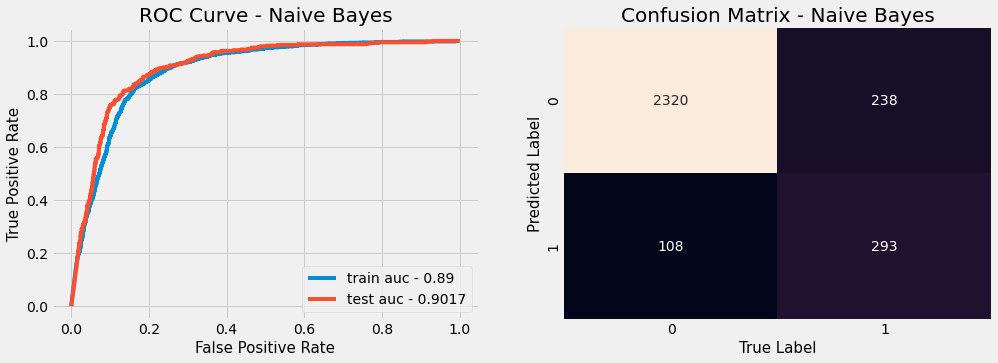

In [87]:
print(classification_report(ytest, yTestPred))

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(fpr_tr, tpr_tr, label = "train auc - " + str(round(auc_train,4)))
plt.plot(fpr_te, tpr_te, label = "test auc - " + str(round(auc_test,4)))
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.title('ROC Curve - Naive Bayes', fontsize=20)
plt.legend()

plt.subplot(122)
sns.heatmap(confusion_matrix(ytest, yTestPred), annot=True, fmt="d", cbar=False)
plt.ylabel('Predicted Label', fontsize=15)
plt.xlabel('True Label', fontsize=15)
plt.title('Confusion Matrix - Naive Bayes', fontsize=20)
plt.show()

### Observations:

1. Model is not overfitting as train and test roc curve as well as auc scores are very close.
2. The minority miss classification rate is not better than the Nearest Centroid method. But there is an overcall performance of F1 score.

## 15. Quadratic Discriminant Analysis

In [88]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

param_grid = {"reg_param" : [i*0.1 for i in range(0,11)]}

hpTuning = GridSearchCV(QuadraticDiscriminantAnalysis(), param_grid, scoring='recall')
hpTuning.fit(xtrain, ytrain)

print("Best cross-validation score: {:.2f}".format(hpTuning.best_score_))
print("Best parameters: ", hpTuning.best_params_)
print("Best Estimator : ", hpTuning.best_estimator_)

Best cross-validation score: 0.71
Best parameters:  {'reg_param': 0.0}
Best Estimator :  QuadraticDiscriminantAnalysis()


In [89]:
model = hpTuning.best_estimator_
model.fit(xtrain, ytrain)

ytrainPred = model.predict(xtrain)
yTestPred = model.predict(xtest)

## get probabilities output
yTrainPredProba = model.predict_proba(xtrain)
yTestPredProba = model.predict_proba(xtest)


## getting tpr, fpr scores wit threshold for train and test data
fpr_tr, tpr_tr, threshold_tr = roc_curve(ytrain,  yTrainPredProba[:, 1])
fpr_te, tpr_te, threshold_te = roc_curve(ytest,  yTestPredProba[:,1])
auc_train = auc(fpr_tr, tpr_tr)
auc_test = auc(fpr_te, tpr_te)

print(f"auc score, train data : {auc_train:.4f}, test data : {auc_test:.4f}")

dfQDA = validationOutput('Quadratic Discriminant Analysis', ytrain, ytrainPred, ytest, yTestPred)

auc score, train data : 0.8843, test data : 0.8952


              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2558
           1       0.50      0.77      0.60       401

    accuracy                           0.86      2959
   macro avg       0.73      0.82      0.76      2959
weighted avg       0.90      0.86      0.88      2959



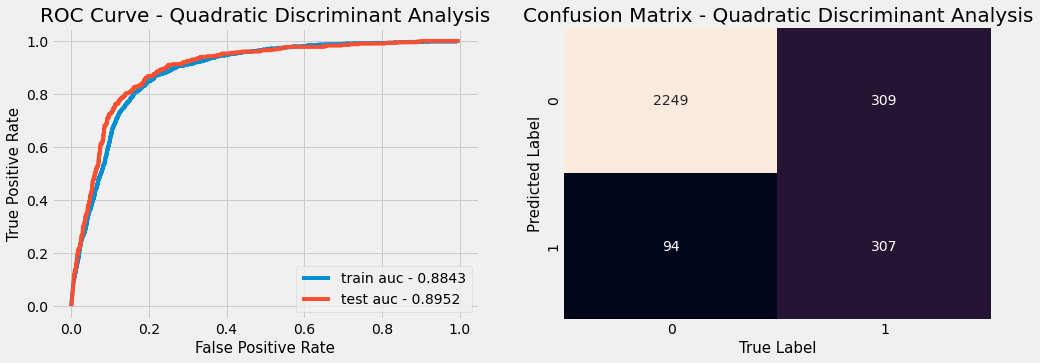

In [90]:
print(classification_report(ytest, yTestPred))

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(fpr_tr, tpr_tr, label = "train auc - " + str(round(auc_train,4)))
plt.plot(fpr_te, tpr_te, label = "test auc - " + str(round(auc_test,4)))
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.title('ROC Curve - Quadratic Discriminant Analysis', fontsize=20)
plt.legend()

plt.subplot(122)
sns.heatmap(confusion_matrix(ytest, yTestPred), annot=True, fmt="d", cbar=False)
plt.ylabel('Predicted Label', fontsize=15)
plt.xlabel('True Label', fontsize=15)
plt.title('Confusion Matrix - Quadratic Discriminant Analysis', fontsize=20)
plt.show()

### Observations:

1. Model is not overfitting as train and test roc curve as well as auc scores are very close.
2. As compared to Nearest centroid and Naive bayes, QDA has descent recall score which is higher than naive bayes but lower than Nearest centroid. The F1 score also low as comapred to them.

## 16. Final Comparsion

In [91]:
pd.concat([dfNC,dfNB,dfQDA])

,ModelName,trainAcc,testAcc,testF1,testPrecision,testRecall
0,Nearest Centroid,0.84,0.86,0.61,0.48,0.82
0,Naive Bayes,0.86,0.88,0.63,0.55,0.73
0,Quadratic Discriminant Analysis,0.85,0.86,0.60,0.50,0.77


### **From the above analysis we found out that the best model amongst three will be QDA. Though it has overall F1 score low, but it has good recall score and a balance score for minority class.**